# Cardio Dataset

## 0.1 Importing the Data

In [1]:
#Opening the file
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.linear_model import LogisticRegression,SGDClassifier
import scipy
import tensorflow as tf
sb.set()

In [2]:
#Reading the file
maindf=pd.read_csv('cardio_train.csv',sep=';')
maindf.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## 1.0 Data Overview

### 1.1 Checking Numerical Data

In [3]:
maindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


Numeric Variables: age, height, weight, ap_hi, ap_lo<br>
Categorical Variables:<br>
> Nominal: gender<br>
> Ordinal: cholesterol, gluc, smoke, alco, active<br>
This was inferred from the data description on Kaggle.

Healthy Patients dims: (35021, 13)
Patients with cardiovascular issues dims: (34979, 13)


<AxesSubplot:title={'center':'%Healthy Patients'}, ylabel='cardio'>

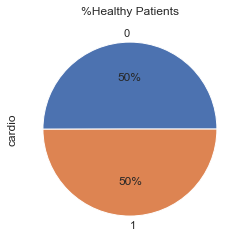

In [4]:
#Split DataSet for Visualization. Cardio0=Healthy Patients Cardio1=Patients with cardiovascular issues
isHealthy = maindf['cardio'] == 0
Cardio0, Cardio1 = maindf[isHealthy], maindf[~isHealthy]
print('Healthy Patients dims:',Cardio0.shape)
print('Patients with cardiovascular issues dims:',Cardio1.shape)
maindf['cardio'].value_counts().plot(kind='pie',autopct='%1.0f%%', title='%Healthy Patients')

Classes are evenly split, the problem of imbalanced classes won't arise here.

In [5]:
#Check for null values in the DataSheet
maindf.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

All fields are filled. There are no missing values in the dataset

In [6]:
dfNumerical=maindf[['age', 'height', 'weight', 'ap_hi', 'ap_lo','cardio']]
dfNumerical.describe()

,age,height,weight,ap_hi,ap_lo,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,164.359229,74.205690,128.817286,96.630414,0.499700
std,2467.251667,8.210126,14.395757,154.011419,188.472530,0.500003
min,10798.000000,55.000000,10.000000,-150.000000,-70.000000,0.000000
25%,17664.000000,159.000000,65.000000,120.000000,80.000000,0.000000
50%,19703.000000,165.000000,72.000000,120.000000,80.000000,0.000000
75%,21327.000000,170.000000,82.000000,140.000000,90.000000,1.000000
max,23713.000000,250.000000,200.000000,16020.000000,11000.000000,1.000000


Note 1: Min weight and height are 10kg and 55cm respectively. However, min age is 29.5years(10798/365). As these numbers do not logically add up, some cleaning is required. <br>
Note 2: Blood Pressure is horribly off. The highest recorded human blood pressure was 370/360mmhg. Hence, values like 16020 and 11000. are definitely off. <br>
Note 3: Diastilic pressure cannot be higher than systolic. (We learned this from the main Kaggle notebook)


In [7]:
print("Diastilic pressure is higher than systolic one in {0} cases".format(maindf[maindf['ap_lo']> maindf['ap_hi']].shape[0]))

Diastilic pressure is higher than systolic one in 1234 cases


## 1.2 Basic Visualization

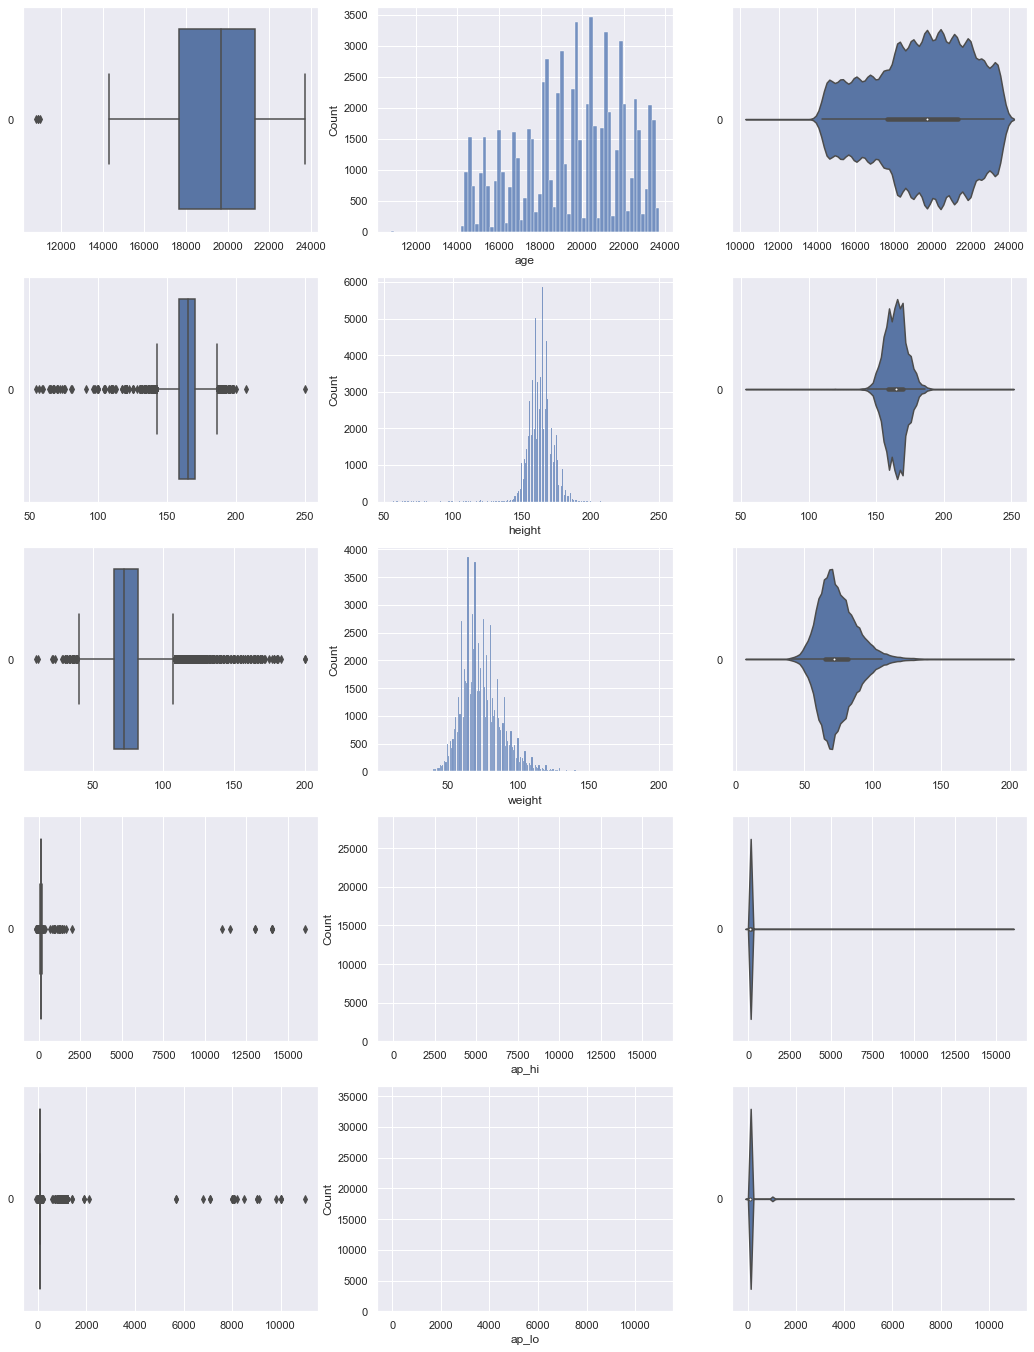

In [8]:
f, axes = plt.subplots(5, 3, figsize=(18, 24))
count = 0
for var in dfNumerical:
    if (var!='cardio'):
        sb.boxplot(data = dfNumerical[var], orient = "h", ax = axes[count,0])
        sb.histplot(data = dfNumerical[var], ax = axes[count,1])
        sb.violinplot(data = dfNumerical[var], orient = "h", ax = axes[count,2])
        count += 1

Evidently, our numerical data contains a few outliers that need to be dealt with.<br>
As age lies between 29.5 years and 64.5 years, a believeable range, we will exclude this variable in outlier removal.

## 1.3 Numerical Data Cleaning

### 1.3.1 Cleaning out Impossible Values

First, we'll need to drop impossible values we know are definitely erratic<br>
Hence, we drop the cases where diastilic pressure is higher than systolic pressure.

In [9]:
bplohi=maindf['ap_hi']<maindf['ap_lo']
maindf.drop(maindf[bplohi].index, inplace=True)
print("Diastilic pressure is higher than systolic one in {0} cases".format(maindf[maindf['ap_lo']> maindf['ap_hi']].shape[0]))

Diastilic pressure is higher than systolic one in 0 cases


In [10]:
print("Filtered DataDims:",maindf.shape)

Filtered DataDims: (68766, 13)


### 1.3.2 Removing Outliers

Next, we drop the outliers. Lets take a look at the makeup of outliers if we use the 'Turkey Fence' method<br>
Convention states that outliers can be defined as any value that lies 3.0 IQR beyond the 1st and 3rd quartiles. (Turkey's Outer Fence)

In [11]:
def flag_outliers(df, var, degree):
    #Getting the interquartile range
    lq = df[var].quantile(0.25)
    uq = df[var].quantile(0.75)
    iqr = uq - lq
    #Generating Upper/Lower Bounds
    lowerbound = lq - degree*iqr
    upperbound = uq + degree*iqr
    #Adding a column with a boolean flag to flag out anomalies
    df['flag'] = 0
    df.loc[(df[var] <= lowerbound) | (df[var] >= upperbound), 'flag'] = 1
    #Show a scatterplot of the values to be dropped
    f, axes = plt.subplots(1, 1, figsize=(16,8))
    plt.scatter(x = var, y = "id", c = "flag", cmap = 'viridis', data = df)
    total=df['flag'].sum()
    print('Total no. of values to be dropped:',total)
    del df['flag']
    return lowerbound, upperbound

In [12]:
def drop_outliers(df, var, lowerbound, upperbound):
    df.drop(df[(df[var] <= lowerbound) | (df[var] >= upperbound)].index,inplace=True)
    print('Outliers dropped. \nNew Boxplot of %s:' % (var))
    #Plot boxplot of variable after dropping
    sb.boxplot(data = df[var], orient = "h")

#### Removing outliers based on ap_hi

Total no. of values to be dropped: 195


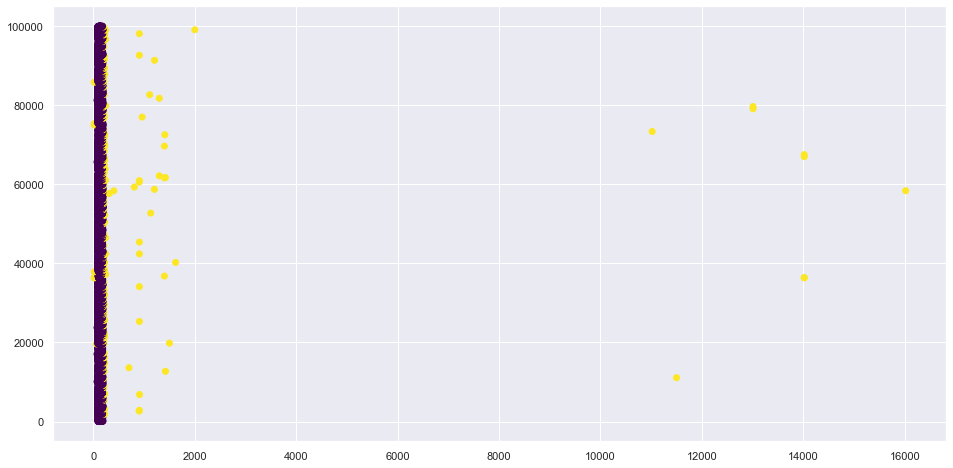

In [13]:
lowerbound, upperbound = flag_outliers(maindf, 'ap_hi', 3)

A scatterplot of the variables we're about to drop. 195/68766=0.28% of the remaining data.

Outliers dropped. 
New Boxplot of ap_hi:


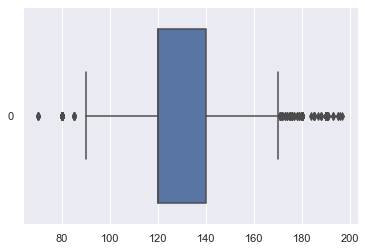

In [14]:
drop_outliers(maindf, 'ap_hi', lowerbound, upperbound)

Based on the boxplot, the data now follows a normal distribution.

Let's check the state of our other variables

In [15]:
maindf.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,68571.000000,68571.00000,68571.000000,68571.000000,68571.000000,68571.000000,68571.000000,68571.000000,68571.000000,68571.000000,68571.000000,68571.000000,68571.000000
mean,49969.259060,19462.82933,1.348354,164.360371,74.091861,126.500868,81.192210,1.363871,1.225095,0.087763,0.053200,0.803445,0.493926
std,28846.774087,2468.79351,0.476452,8.186520,14.307359,16.287805,9.487811,0.678382,0.571000,0.282952,0.224434,0.397396,0.499967
min,0.000000,10798.00000,1.000000,55.000000,11.000000,70.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,24994.500000,17656.00000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50005.000000,19700.00000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74864.500000,21323.00000,2.000000,170.000000,82.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.00000,2.000000,250.000000,200.000000,197.000000,182.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


The spread of ap_lo seems to have improved tremendously as well. However, height and weight still need adjustment.

#### Removing outliers based on height

Total no. of values to be dropped: 89


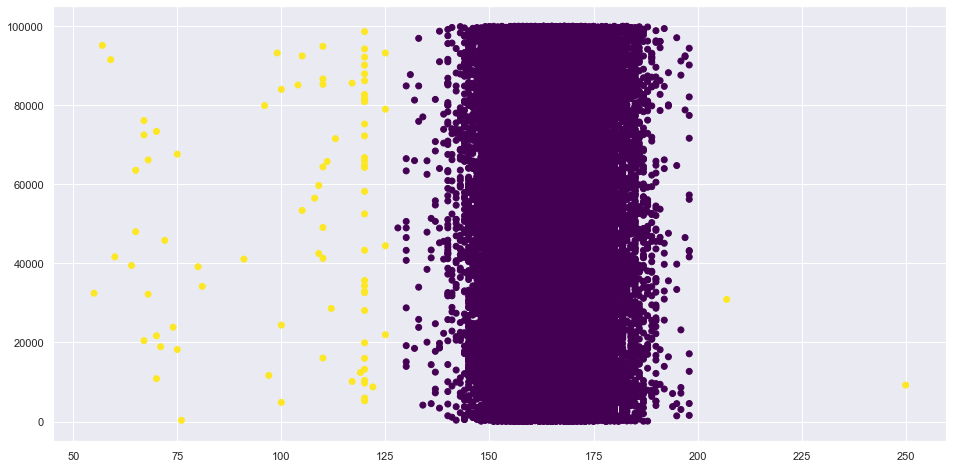

In [16]:
lowerbound, upperbound = flag_outliers(maindf, 'height', 3)

Again, these values look about right. 89/68766=0.12% of total values to be dropped.

Outliers dropped. 
New Boxplot of height:


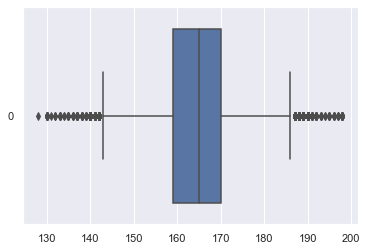

In [17]:
drop_outliers(maindf, 'height', lowerbound, upperbound)

#### Removing outliers based on weight

Total no. of values to be dropped: 160


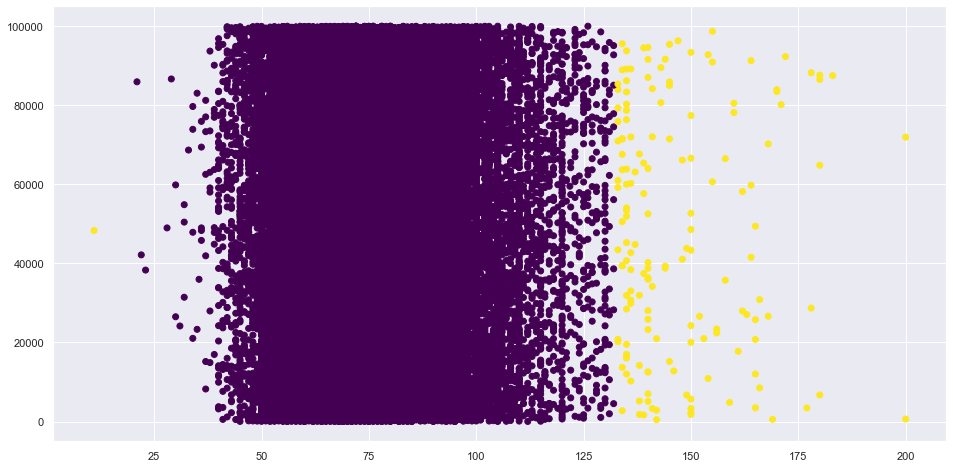

In [18]:
lowerbound, upperbound = flag_outliers(maindf, 'weight', 3)

160/68766=0.23% of total values to be dropped.

Outliers dropped. 
New Boxplot of weight:


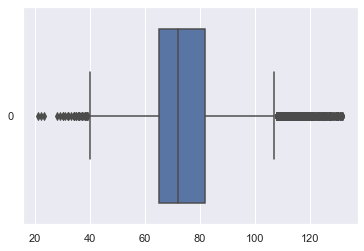

In [19]:
drop_outliers(maindf, 'weight', lowerbound, upperbound)

In [20]:
maindf.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,68322.000000,68322.00000,68322.000000,68322.000000,68322.000000,68322.000000,68322.000000,68322.000000,68322.000000,68322.000000,68322.000000,68322.000000,68322.000000
mean,49972.840783,19464.38440,1.348116,164.423861,73.912684,126.474401,81.178493,1.363558,1.224569,0.087644,0.053072,0.803519,0.493384
std,28842.164472,2468.54202,0.476377,7.836948,13.831609,16.270779,9.474229,0.678157,0.570487,0.282778,0.224179,0.397340,0.499960
min,0.000000,10798.00000,1.000000,128.000000,21.000000,70.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.250000,17657.00000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50011.000000,19701.00000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74856.750000,21325.00000,2.000000,170.000000,82.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.00000,2.000000,198.000000,132.000000,197.000000,182.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


Seems like we still need to drop some outliers from ap_lo. Negative values for blood pressure was probably caused by erratic data entry.

#### Removing outliers based on ap_lo

Total no. of values to be dropped: 277


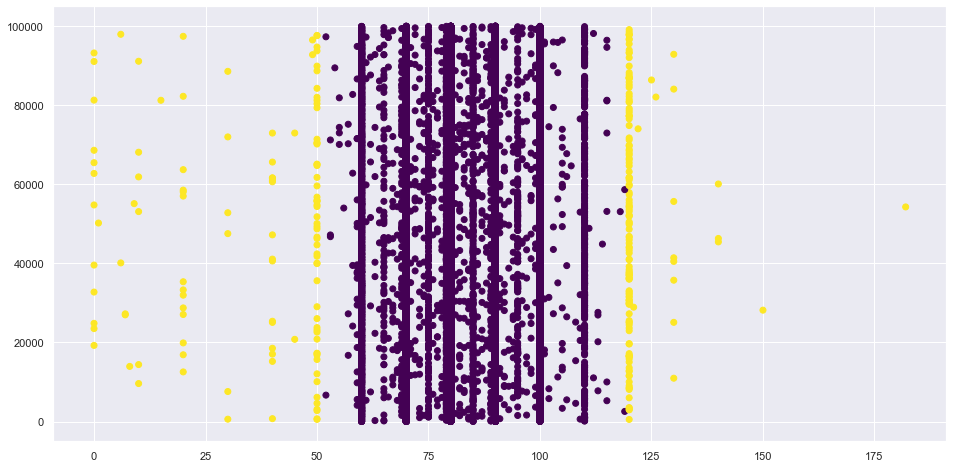

In [21]:
lowerbound, upperbound = flag_outliers(maindf, 'ap_lo', 3)

The values marked for dropping have fallen within the believable range.<br>
Considering most of this data has been scrubbed by the previous filtering of ap_hi, seems like we should relax the parameters.<br>
In this case, we only want to drop the more 'unbelievable' values.

Total no. of values to be dropped: 51


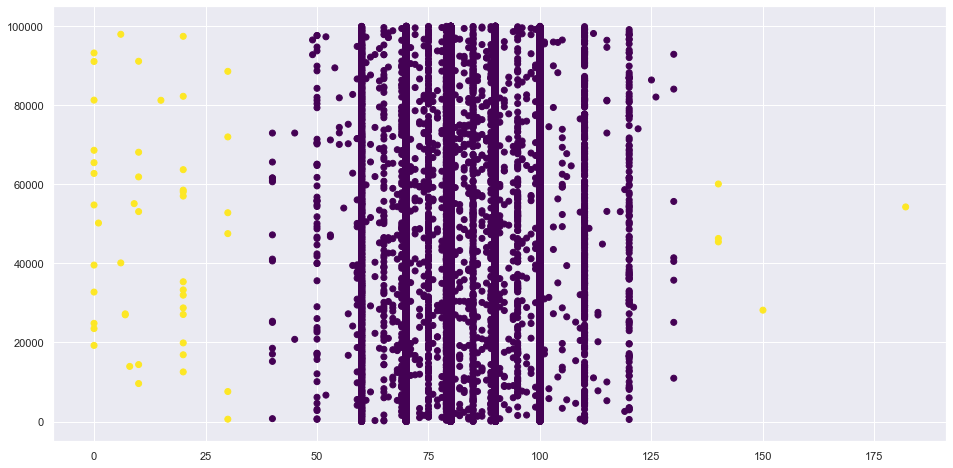

In [22]:
lowerbound, upperbound = flag_outliers(maindf, 'ap_lo', 5)

51/68766=0.07% of total values to be dropped.

Outliers dropped. 
New Boxplot of ap_lo:


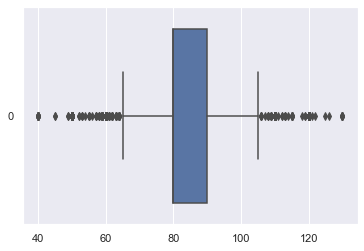

In [23]:
drop_outliers(maindf, 'ap_lo', lowerbound, upperbound)

### 1.3.3 Overall Shape Of Cleaned Data

In [24]:
maindf.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,68271.000000,68271.000000,68271.000000,68271.000000,68271.000000,68271.000000,68271.000000,68271.000000,68271.000000,68271.000000,68271.000000,68271.000000,68271.000000
mean,49973.927612,19464.580613,1.348113,164.423708,73.913249,126.470844,81.219639,1.363536,1.224663,0.087651,0.053083,0.803474,0.493372
std,28844.168991,2468.523183,0.476375,7.837376,13.831120,16.262321,9.285198,0.678127,0.570606,0.282788,0.224200,0.397373,0.499960
min,0.000000,10798.000000,1.000000,128.000000,21.000000,70.000000,40.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25002.500000,17657.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50010.000000,19701.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74860.500000,21325.500000,2.000000,170.000000,82.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,198.000000,132.000000,197.000000,130.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
print (maindf.shape)

(68271, 13)


The data seems sufficiently clean. We have removed about 2.47% of the original values as outliers.

## 1.4 Exploratory Analysis

### 1.4.1 Basic Plots

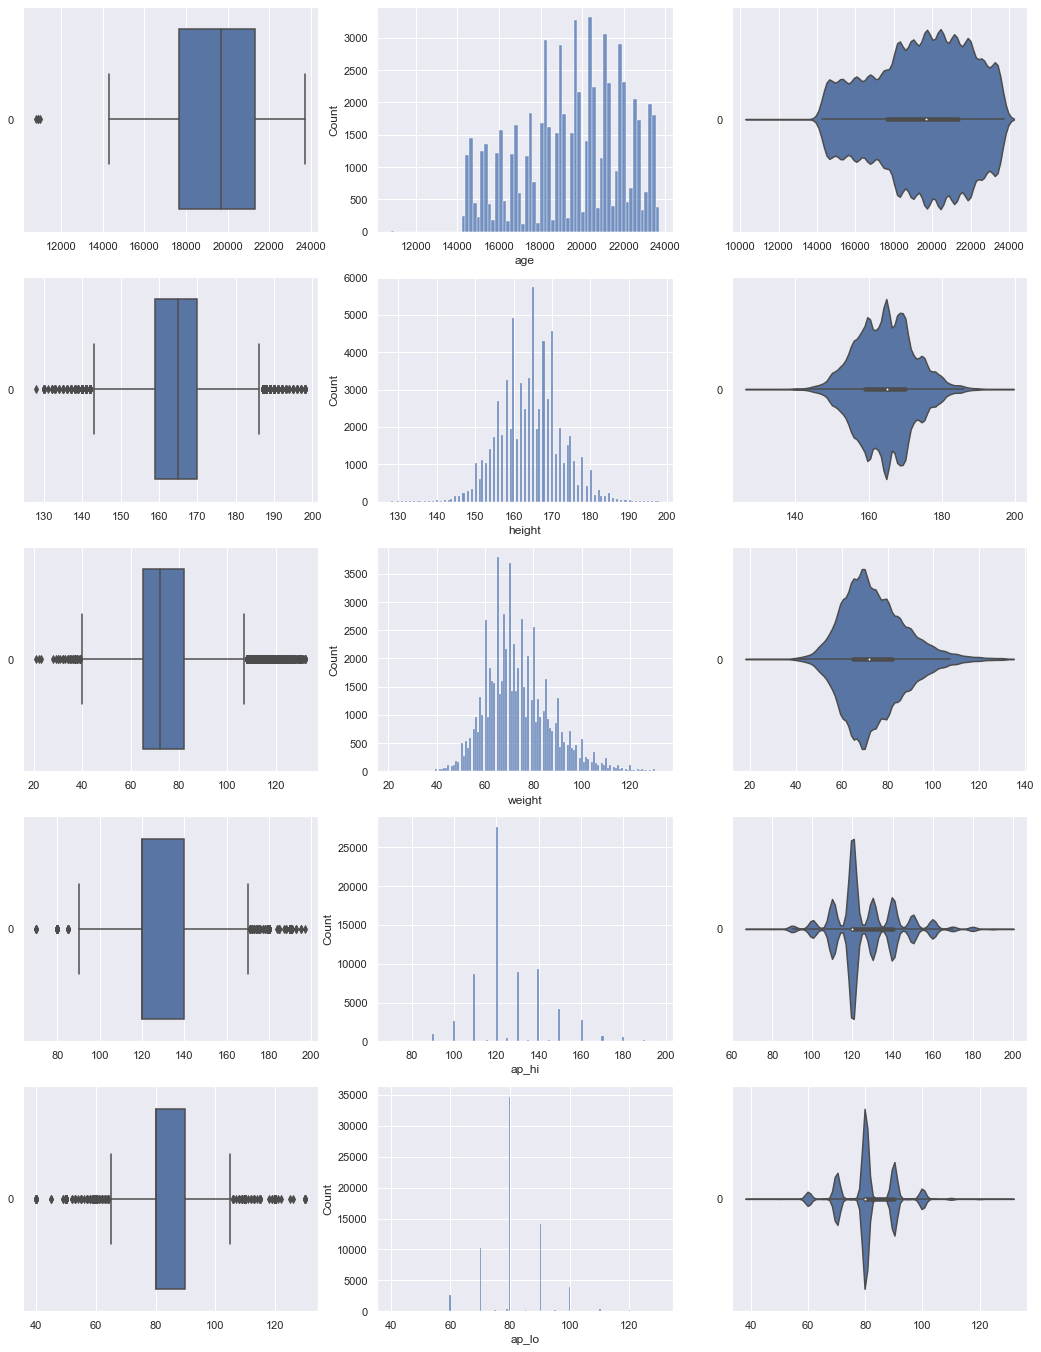

In [26]:
dfNumerical=maindf[['age', 'height', 'weight', 'ap_hi', 'ap_lo','cardio']]
f, axes = plt.subplots(5, 3, figsize=(18, 24))
count = 0
for var in dfNumerical:
    if (var!='cardio'):
        sb.boxplot(data = dfNumerical[var], orient = "h", ax = axes[count,0])
        sb.histplot(data = dfNumerical[var], ax = axes[count,1])
        sb.violinplot(data = dfNumerical[var], orient = "h", ax = axes[count,2])
        count += 1

Age height and weight now seem to follow a normal distribution.<br> ap_hi and ap_lo now form a clustered normal distribution.

### 1.4.2 Correlation Heatmap

<AxesSubplot:>

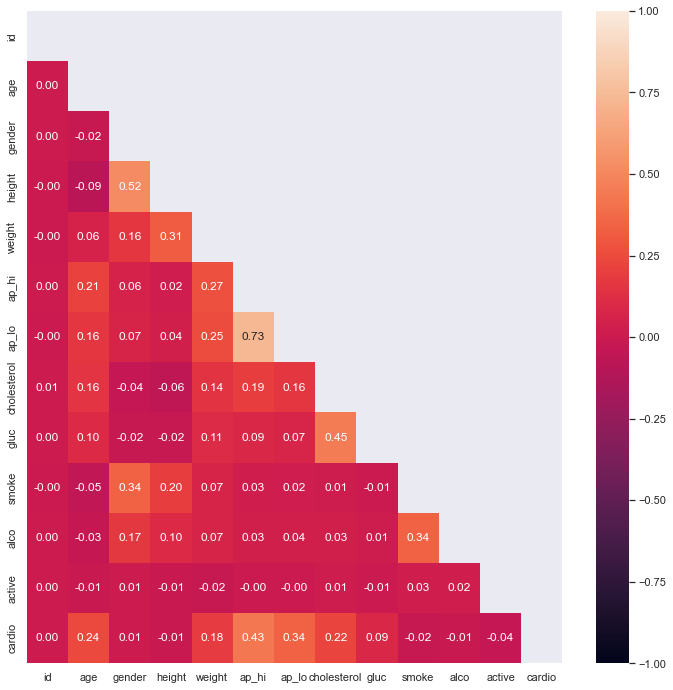

In [27]:
#Plotting a correlation matrix between the variables
f = plt.figure(figsize=(12, 12))
mask = np.triu(np.ones_like(maindf.corr(), dtype=bool))
sb.heatmap(maindf.corr(), mask=mask, vmin = -1, vmax = 1, annot = True, fmt = ".2f")


Seems the prescence of CDV is mostly affected by the BP of a patient, followed by their cholestrol levels.

# 2.0 Level-0 Models

### 2.0.1 Normalizing input Data

We will now proceed to normalize our numerical input variables. Currently, the range of values vary greatly between the different numerical variables. For example, the age variable lies in the interval [10798,23713] while the weight variable lies in the interval [21,132]. This could potentially cause the gradient descent algorithm of our neural network to oscillate, making it difficult for the algorithm to converge on the global minimum. <br><br>
Hence, to stabilize the gradient descent for our MLP, we will normalize all our numerical variables.<br><br>
The normalization of numerical data will not affect the accuracy of our other models. This is because:<br><br>
Decision Tree: The gini impurity function is not affected by a monotonic transformation such as normalization. As the order of our data is preserved, we will obtain the same tree.<br><br>
Logistic Regression: Normalization in this case may actually speed up the convergence for the sigmoid function.<br><br>
Naive-Bayes: The parameters within the Baye's theorem will be rescaled to fit the normalized data. As Naive-Bayes assumes independence, the normalization will not afffect the accuracy of the classifier.

In [28]:
#Remove the id variable as it carries no real meaning.
del maindf['id']

maindf_numerical=maindf[['age','height','weight','ap_hi','ap_lo']].copy()
#Normalize using (input-mean)/std deviation
maindf_numerical_normalized =(maindf_numerical-maindf_numerical.mean())/maindf_numerical.std()
maindf = maindf.drop(['age','height','weight','ap_hi','ap_lo'], axis=1)
maindf = pd.concat([maindf_numerical_normalized, maindf],axis=1)
maindf.describe()

,age,height,weight,ap_hi,ap_lo,gender,cholesterol,gluc,smoke,alco,active,cardio
count,6.827100e+04,6.827100e+04,6.827100e+04,6.827100e+04,6.827100e+04,68271.000000,68271.000000,68271.000000,68271.000000,68271.000000,68271.000000,68271.000000
mean,-7.899267e-17,-3.089780e-20,-1.293127e-15,-4.320496e-16,-6.978691e-16,1.348113,1.363536,1.224663,0.087651,0.053083,0.803474,0.493372
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.476375,0.678127,0.570606,0.282788,0.224200,0.397373,0.499960
min,-3.510836e+00,-4.647436e+00,-3.825666e+00,-3.472496e+00,-4.439285e+00,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.322518e-01,-6.920311e-01,-6.444344e-01,-3.979041e-01,-1.313531e-01,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,9.577361e-02,7.353118e-02,-1.383293e-01,-3.979041e-01,-1.313531e-01,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,7.538594e-01,7.114998e-01,5.846780e-01,8.319326e-01,9.456299e-01,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,1.721037e+00,4.284124e+00,4.199714e+00,4.336967e+00,5.253562e+00,2.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


### 2.0.2 One-Hot Encoding

The categorical variables in this data have already been encoded using integer encoding.<br>
This is ideal in the case of ordinal data. However, gender, being a nominal variable, should not be encoded as such. By using this encoding, models are allowed to assume a natural ordering between categories, likely resulting in poor performance.<br>
Hence, we resolve this through One-Hot encoding, splitting the category of male and female into two seperate categories denoted by 0 and 1 to remove the suggestion of natural order.

#### Define a function to perform One-Hot Encoding on the Gender Variable:

In [29]:
def dummy_genders(df):
    #One-Hot Encoding using the Pandas get_dummies function
    genderdf=pd.get_dummies( df['gender'])
    genderdf.columns=['Female','Male']
    #Concat this back onto main DataFrame
    df_processed = pd.concat([df,genderdf], axis=1)
    del df_processed ['gender']
    return df_processed

In [30]:
maindf=dummy_genders(maindf)

### 2.0.3 Splitting of Training and Test Data.

We will split the test set into train (75%) and test (25%) sets.

In [31]:
from sklearn.model_selection import train_test_split
ptrain, ptest = train_test_split(maindf, test_size = 0.25)

In [32]:
print(ptrain.shape)
ptrain.head()

(51203, 13)


,age,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,Female,Male
66305,0.129802,-0.692031,-1.005938,-1.012822,-0.131353,1,1,0,0,1,0,1,0
21012,-2.012369,-1.457593,-2.162750,-1.627741,-1.208336,1,1,0,0,1,0,1,0
21824,0.648736,-1.840375,-1.439742,0.217014,-0.131353,1,1,0,1,1,0,1,0
60597,0.925825,-0.054063,-0.391382,-1.012822,-1.208336,3,3,0,0,1,0,0,1
26741,0.727325,-0.054063,1.307685,3.291606,2.022613,3,3,0,0,1,1,0,1


In [33]:
print(ptest.shape)
ptest.head()

(17068, 13)


,age,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,Female,Male
28746,0.130612,0.711500,-0.282931,0.217014,-0.131353,1,1,0,0,1,0,0,1
15879,1.000363,0.328719,-1.005938,-0.397904,-0.131353,1,1,0,0,1,0,0,1
886,1.254766,-0.564437,-0.138329,2.676688,0.945630,1,2,0,0,0,0,1,0
33473,-0.193063,-1.712781,-0.210630,-0.397904,-1.208336,2,1,0,0,1,1,1,0
33253,0.111978,-0.819625,2.536798,-0.397904,-0.131353,1,1,0,0,1,1,1,0


#### Creating Target Variable:

In [34]:
#Pop the target data from the dataset
ptrain_target=ptrain.pop('cardio')
ptest_target=ptest.pop('cardio')

### 2.0.4 Creating a list of all our level 0 models

In [35]:
base_models = list()

## 2.1 Decision Tree

The following code constructs a decision tree and tests for the optimal depth of the decision tree, returning the tree with optimal depth.

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.7319102396343964

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.7282048277478322

[0.7122685727677526, 0.7122685727677526, 0.7219943754394188, 0.7251581907663464, 0.7282048277478322, 0.7270916334661355, 0.7298453245840169, 0.7296109678931334, 0.7258026716662761, 0.7201781110850715, 0.7171314741035857, 0.7146121396765878, 0.7095148816498711, 0.7061752988047809]


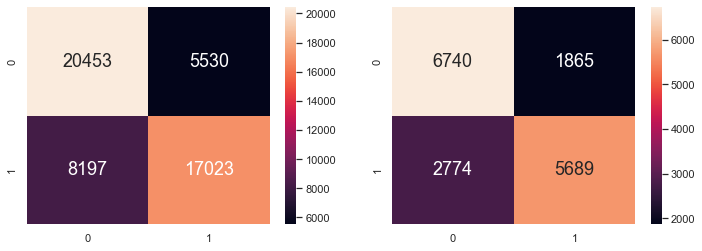

In [36]:
#importing some essential libraries

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#Defining the decision tree
dectree = DecisionTreeClassifier(max_depth = 5) # create the decision tree ob
dectree.fit(ptrain, ptrain_target) #train

#predict
ptrain_target_pred = dectree.predict(ptrain)
ptest_target_pred = dectree.predict(ptest)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(ptrain, ptrain_target))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(ptest, ptest_target))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(ptrain_target, ptrain_target_pred),
 annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(ptest_target, ptest_target_pred),
 annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

#A function to test for the optimal max depth

max_depth_optimal = list(range(1,15))

depth_accuracy = []

for maxdepth in max_depth_optimal:
 clf = DecisionTreeClassifier(max_depth = maxdepth,random_state = 0)
 clf.fit(ptrain, ptrain_target)
 score = clf.score(ptest, ptest_target)
 depth_accuracy.append(score)
print(depth_accuracy)

#optimal range is at max depth = 5

In [37]:
# Plot the Decision Tree
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(200, 100))
out = plot_tree(dectree,
 feature_names = ptrain.columns,
 class_names = [str(x) for x in dectree.classes_],
 filled=True)

for o in out:
     arrow = o.arrow_patch
     if arrow is not None:
         arrow.set_edgecolor('red')
         arrow.set_linewidth(4)

Seems the prescence of CDV is mostly affected by the BP of a patient, followed by their cholestrol levels.

In [38]:
#Add this model to our master list
base_models.append(dectree)

## 2.2 Logistic Regression

Since we have a binary classification problem, a logistic regression model might be suitable in predicting our target variable.

In [39]:
#Creating the Logistic Regression Model and fitting the data.
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=45, max_iter=500).fit(ptrain, ptrain_target)
print("LogReg model trained, Accuracy \t:", logreg.score(ptrain, ptrain_target))

LogReg model trained, Accuracy 	: 0.7279846883971642


In [40]:
#Use LinReg to predict the test set's target value
pred_target = logreg.predict(ptest)

Test Accuracy 	: 0.723869228966487


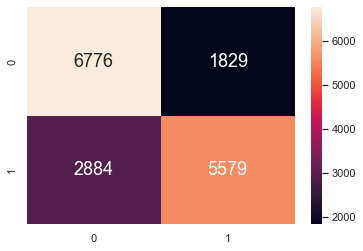

In [41]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(ptest_target,pred_target), 
           annot = True, fmt=".0f", annot_kws={"size": 18})
print("Test Accuracy \t:", logreg.score(ptest, ptest_target))

71 percent... not too accurate. Perhaps the Logistic Regression model cannot capture all our variables accurately.

In [42]:
#Add this model to our master list
base_models.append(logreg)

## 2.3 Naive-Bayes

The following code constructs a simple Gaussian Naive-Bayes model to classify the data.

In [43]:
#Creating the Gaussian NB and fitting the data.
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB().fit(ptrain,ptrain_target)
print("Naive-Bayes model trained, Accuracy \t:", NB.score(ptrain, ptrain_target))

Naive-Bayes model trained, Accuracy 	: 0.7132394586254711


In [44]:
#Use NB to predict the test set's target value
pred_target = NB.predict(ptest)

Test Accuracy 	: 0.710569486758847


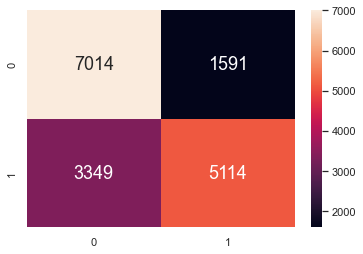

In [45]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(ptest_target,pred_target), 
           annot = True, fmt=".0f", annot_kws={"size": 18})
print("Test Accuracy \t:", NB.score(ptest, ptest_target))

The Gaussian NB has a significantly smaller number of false negatives.

In [46]:
#Add this model to our master list
base_models.append(NB)

## 2.4 MultiLayer Perceptron (MLP)

### 2.4.1 Data Preprocessing for Neural Networks

Neural Networks require a set of validation data to assess the test error rate. Hence, we further split our train data to achieve an overall split of (50,25,25) for our train, validation and test data respectively.

In [47]:
ptrain=pd.concat([ptrain, ptrain_target], axis=1)
ptrain, pval = train_test_split(ptrain, test_size = (1.0/3))
ptrain_target = ptrain.pop('cardio')
pval_target = pval.pop('cardio')

As TensorFlow takes in its variables as tensors, we need to convert our dataframe into a NumPy array representing each entry as a tensor.

In [48]:
#Converting the training Data into tensors for Keras
ptrain_tensor=ptrain.copy(deep=True)
ptrain_tensor=tf.convert_to_tensor(ptrain_tensor)
#Converting the validation Data into tensors for Keras
pval=tf.convert_to_tensor(pval)
#Converting the Test Data into tensors for Keras
ptest_tensor=ptest.copy(deep=True)
ptest_tensor=tf.convert_to_tensor(ptest_tensor)

### 2.4.2 Building the MLP model

In [49]:
from keras import initializers

As our problem is one of binary classification, we will utilize the binary crossentropy function as the loss function in the training of our model.<br>
The sigmoid activation function of the output node will also ensure the output value of the final node is between 0-1. This means the the output node effectively produces a probability form 0-1 representing the patient's likelihood of having a cardiac disease.<br>

In [50]:
#We build a network with 1 hidden layer and one output layer.
def get_MLP(seed):
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(12, activation='relu',
                         kernel_initializer=initializers.glorot_uniform(seed=seed)),
    tf.keras.layers.Dense(7, activation='relu',
                         kernel_initializer=initializers.glorot_uniform(seed=seed)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                         kernel_initializer=initializers.glorot_uniform(seed=seed))
      #Since we are building a binary classifier, a sigmoid activation fn is used at the last node to ensure 0<output<1
  ])

  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

### 2.4.3 Training the MLP

In [51]:
#Using a standard batch size of 64 and an epoch of size 36((11inputs+1output)x3)
#We train our model

BATCH_SIZE=64
MLP = get_MLP(4)
#Early stopping fn to prevent overfitting of model.
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="accuracy", 
                                        mode ="max", patience = 5, 
                                        restore_best_weights = True)

MLP.fit(ptrain_tensor, ptrain_target, validation_data=(pval, pval_target),
        epochs=36, batch_size=BATCH_SIZE, callbacks =[earlystopping])

Epoch 1/36
534/534 [==============================] - 3s 3ms/step - loss: 0.6057 - accuracy: 0.6882 - val_loss: 0.5552 - val_accuracy: 0.7293
Epoch 2/36
534/534 [==============================] - 2s 3ms/step - loss: 0.5531 - accuracy: 0.7282 - val_loss: 0.5528 - val_accuracy: 0.7303
Epoch 3/36
534/534 [==============================] - 1s 3ms/step - loss: 0.5501 - accuracy: 0.7300 - val_loss: 0.5497 - val_accuracy: 0.7318
Epoch 4/36
534/534 [==============================] - 2s 3ms/step - loss: 0.5486 - accuracy: 0.7315 - val_loss: 0.5493 - val_accuracy: 0.7325
Epoch 5/36
534/534 [==============================] - 1s 3ms/step - loss: 0.5481 - accuracy: 0.7312 - val_loss: 0.5481 - val_accuracy: 0.7325
Epoch 6/36
534/534 [==============================] - 1s 3ms/step - loss: 0.5472 - accuracy: 0.7304 - val_loss: 0.5491 - val_accuracy: 0.7336
Epoch 7/36
534/534 [==============================] - 1s 2ms/step - loss: 0.5471 - accuracy: 0.7315 - val_loss: 0.5473 - val_accuracy: 0.7336
Epoch 

### 2.4.4 Testing the MLP model

In [52]:
#Using the test data, we test the accuracy of our model
test_loss, test_acc = MLP.evaluate(ptest_tensor,  ptest_target, verbose=1) 

print('Test accuracy:', test_acc)

534/534 [==============================] - 1s 1ms/step - loss: 0.5460 - accuracy: 0.7300
Test accuracy: 0.7299625277519226


534/534 [==============================] - 0s 704us/step


<AxesSubplot:>

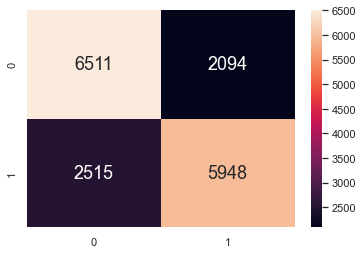

In [53]:
#Lets plot a confusion matrix for our results.
from sklearn.metrics import confusion_matrix
predicted = MLP.predict(ptest_tensor)
pred_target = [1 * (x[0]>=0.5) for x in predicted]
sb.heatmap(confusion_matrix(ptest_target,pred_target), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Seems our models are good at predicting true negatives. 

In [54]:
#Add this model to our master list
base_models.append(MLP)

## 3.0 Level 0 Model Metrics

We will evaluate our models based on the following metrics:

1. Mean Squared Error, which we have used as a common loss function among the models
2. Bias, E(x)-x. This can be visualised as how "accurate" a model is
3. Variance, how “jumpy” the gap between the real model and the predictor model is. This can be visualised as the "precision" of a model.

## 3.1 MSE, Bias and Variance

In [55]:
from mlxtend.evaluate import bias_variance_decomp

In [56]:
def get_modelname(i):
    if i==1:
        return 'Decision Tree'
    elif i==2:
         return 'Logistic Regression'
    elif i==3:
         return 'Naive Bayes'
    elif i==4:
         return 'MultiLayer Perceptron'
        

In [57]:
i=1
L0_metrics = pd.DataFrame(columns = ['Model', 'MSE', 'Bias', 'Variance'])
for model in base_models:
    if i==4:
        mse, bias, var = bias_variance_decomp(model, ptrain.to_numpy(), ptrain_target.to_numpy(), ptest.to_numpy(), 
                                               ptest_target.to_numpy(), loss='mse', num_rounds=10, random_seed=1, epochs=10, verbose=0)
    else:
        mse, bias, var = bias_variance_decomp(model, ptrain.to_numpy(), ptrain_target.to_numpy(), ptest.to_numpy(), 
                                               ptest_target.to_numpy(), loss='mse', num_rounds=10, random_seed=1)
    msebiasvar={'Model': [get_modelname(i)], 'MSE': [mse], 'Bias': [bias], 'Variance': [var]}
    L0_metrics=pd.concat([L0_metrics,pd.DataFrame(data=msebiasvar)], 
     ignore_index=True)
    i=i+1
    
print(L0_metrics)

534/534 [==============================] - 0s 707us/step
                   Model       MSE      Bias  Variance
0          Decision Tree  0.273453  0.243414  0.030039
1    Logistic Regression  0.275457  0.270203  0.005254
2            Naive Bayes  0.288839  0.284313  0.004526
3  MultiLayer Perceptron  0.182566  0.181772  0.000794


As we can see, our models all have a low variance but a relatively high bias.
Of the models, the MLP has the lowest MSE. This means the MLP has the lowest number of erroneous predictions among our models.

## 3.2 Model accuracy

In [58]:
L0_accuracy =  pd.DataFrame(columns = ['Model', 'Accuracy'])
i=1
for model in base_models:
    if i==4:
        loss,acc = model.evaluate(ptest, ptest_target, verbose=0)
        
    else:
        acc = model.score(ptest.values, ptest_target)
        
    accuracy={'Model': [get_modelname(i)], 'Accuracy': [acc]}
    L0_accuracy=pd.concat([L0_accuracy,pd.DataFrame(data=accuracy)], 
    ignore_index=True)
    i=i+1
    
print(L0_accuracy) 

                   Model  Accuracy
0          Decision Tree  0.726974
1    Logistic Regression  0.725100
2            Naive Bayes  0.711507
3  MultiLayer Perceptron  0.731310


Here we see the Decision Tree has the highest accuracy between our 4 models, with the MLP coming in a close second. The NB and LogReg models are about 2.5% less accurate than our top 2 models

# 4.0 Ensemble Modeling

As the variance of our models seem relatively low, the meta-model should focus on decreasing the bias of our individual models.
We plan to achieve this by creating a Deep Neural Network to take in the stacked outputs of our Level 0 models.

The intuitive reasoning behind stacking multiple models together is that the various sub-models may have captured different aspects of the data. By feeding the predicted outputs through another model, we may be able to account for the shortcomings of the various individual models.

It is to be noted however, that a stacked model may not necessarily outperform the individual models, as we shall soon see (spoilers :P)

## 4.1 Creating a Training Dataset for the Meta-Model

To create a Level 1 dataset, we must first take the raw data and pass it through the Level 0 models, outputting an array of size (68271,4)

In [59]:
#Generate a Level 1 Array of predictions from base models
def get_L1_data(base_models, data):
    #Creating an array to store predicted values
    pred_arr = None
    #Create a version of data as tensors
    dcopy=data.copy(deep=True)
    data_cardio=dcopy.pop('cardio')
    data_tensor=dcopy.copy(deep=True)
    tf.convert_to_tensor(data_tensor)
    i=1
    for model in base_models:
        if model==MLP:
            pred= np.reshape(model.predict(data_tensor, verbose=0), (-1, 1))
        else:
            pred= np.reshape(model.predict(dcopy.values), (-1, 1))
            
        if pred_arr is None:
            pred_arr=pred
        else:
            pred_arr=np.concatenate((pred_arr, pred), axis=1)
    pred_df=pd.DataFrame(pred_arr, columns = ['DecTree','LogReg','NB','MLP'])
    data_cardio.reset_index(drop=True, inplace=True)
    pred_df=pd.concat([pred_df,data_cardio],axis=1)
    return pred_df

In [60]:
#Create the Level 1 Dataset
L1_data = get_L1_data(base_models,maindf)
print(L1_data)

       DecTree  LogReg   NB       MLP  cardio
0          0.0     0.0  0.0  0.197060       0
1          1.0     1.0  1.0  0.822298       1
2          1.0     1.0  1.0  0.789848       1
3          1.0     1.0  1.0  0.871011       1
4          0.0     0.0  0.0  0.157586       0
...        ...     ...  ...       ...     ...
68266      0.0     0.0  0.0  0.242541       0
68267      1.0     1.0  1.0  0.753588       1
68268      1.0     1.0  1.0  0.927544       1
68269      1.0     1.0  1.0  0.667001       1
68270      0.0     1.0  0.0  0.512744       0

[68271 rows x 5 columns]


In [61]:
#Split the L1 data into train, validation and test sets.
L1_train,L1_test = train_test_split(L1_data, test_size = 0.25)
L1_train, L1_val = train_test_split(L1_train, test_size = (1.0/3))

In [62]:
#Pop target variable
L1_train_target = L1_train.pop('cardio')
L1_val_target = L1_val.pop('cardio')
L1_test_target = L1_test.pop('cardio')

In [63]:
#Convert to tensors
L1_train_tensor=tf.convert_to_tensor(L1_train)
L1_val_tensor=tf.convert_to_tensor(L1_val)
L1_test_tensor=tf.convert_to_tensor(L1_test)

## 4.2 Building the meta-model

### 4.2.1 Meta-model Structure

This function creates and fits the model and returns the trained neural network
The basic structure of this network is a simple DNN with one input layer of 4 nodes, one hidden layer of 2 nodes and a single output node.

In [64]:
def fit_meta(L1_train, L1_train_target,L1_val,L1_val_target):
    #Create the meta-model object
    meta_model= tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation='relu',
                         kernel_initializer=initializers.glorot_uniform(seed=4)),
    tf.keras.layers.Dense(2, activation='relu',
                         kernel_initializer=initializers.glorot_uniform(seed=4)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                         kernel_initializer=initializers.glorot_uniform(seed=4))
      #Since we are building a binary classifier, a sigmoid activation fn is used at the last node to ensure 0<output<1
      ])

    meta_model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
    

    BATCH_SIZE=64
    from keras import callbacks
    earlystopping_meta = callbacks.EarlyStopping(monitor ="accuracy", 
                                        mode ="max", patience = 5, 
                                        restore_best_weights = True)

    meta_model.fit(L1_train_tensor, L1_train_target, validation_data=(L1_val_tensor, L1_val_target),
                   epochs=20, batch_size=BATCH_SIZE, callbacks =[earlystopping_meta])
    return meta_model

### 4.2.2 Predicting and Evaluating the Model

We now simplfy the functions for predicting values using the meta-model, as well as the function to evaluate the meta-model.

In [65]:
def meta_predict(base_models, meta_model, ptrain):
    L1_data = get_L1_data(base_models, ptrain)
    predicted = meta_model.predict(L1_data, verbose=0)
    return predicted

def meta_evaluate(base_models, meta_model, ptest, ptest_target):
    L1_data = get_L1_data(base_models, ptest)
    test_loss, test_acc = meta_model.evaluate(L1_data,  ptest_target, verbose=1) 
    print('Test accuracy:', test_acc)
    return test_acc

## 4.3 Training the model

In [66]:
meta_model=fit_meta(L1_train_tensor, L1_train_target,L1_val,L1_val_target)

Epoch 1/20
534/534 [==============================] - 2s 3ms/step - loss: 0.6132 - accuracy: 0.7222 - val_loss: 0.5886 - val_accuracy: 0.7267
Epoch 2/20
534/534 [==============================] - 1s 3ms/step - loss: 0.5763 - accuracy: 0.7290 - val_loss: 0.5726 - val_accuracy: 0.7297
Epoch 3/20
534/534 [==============================] - 1s 3ms/step - loss: 0.5660 - accuracy: 0.7315 - val_loss: 0.5665 - val_accuracy: 0.7296
Epoch 4/20
534/534 [==============================] - 1s 3ms/step - loss: 0.5613 - accuracy: 0.7307 - val_loss: 0.5627 - val_accuracy: 0.7281
Epoch 5/20
534/534 [==============================] - 1s 3ms/step - loss: 0.5580 - accuracy: 0.7307 - val_loss: 0.5593 - val_accuracy: 0.7294
Epoch 6/20
534/534 [==============================] - 1s 3ms/step - loss: 0.5551 - accuracy: 0.7309 - val_loss: 0.5567 - val_accuracy: 0.7301
Epoch 7/20
534/534 [==============================] - 1s 3ms/step - loss: 0.5527 - accuracy: 0.7308 - val_loss: 0.5549 - val_accuracy: 0.7311
Epoch 

## 4.4 Model Performance

534/534 [==============================] - 1s 1ms/step - loss: 0.5486 - accuracy: 0.7294
Test accuracy: 0.7294352054595947


<AxesSubplot:>

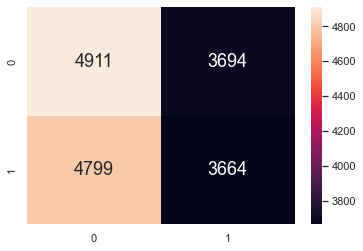

In [67]:
test_loss, test_acc = meta_model.evaluate(L1_test_tensor,  L1_test_target, verbose=1) 
print('Test accuracy:', test_acc)

from sklearn.metrics import confusion_matrix
meta_predictions = meta_model.predict(L1_test_tensor, verbose=0)
pred_target = [1 * (x[0]>=0.5) for x in meta_predictions]
sb.heatmap(confusion_matrix(ptest_target,pred_target), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Seems the model performed similarly to the MLP.

# 5.0 Final Discussions.

## 5.1 MSE, Bias, Variance

As usual, we will evalaute the performance of our models based on MSE, bias and variance.

In [68]:
mse, bias, var = bias_variance_decomp(meta_model, L1_train.to_numpy(), L1_train_target.to_numpy(), L1_test.to_numpy(), 
                                               L1_test_target.to_numpy(), loss='mse', num_rounds=10, random_seed=1, epochs=10, verbose=0)
print('MSE: %.3f' % mse)
print('Bias: %.3f' % bias)
print('Variance: %.3f\n' % var)
msebiasvar_meta={'Model': ['Meta-Model'], 'MSE': [mse], 'Bias': [bias], 'Variance': [var]}

534/534 [==============================] - 0s 654us/step
MSE: 0.185
Bias: 0.184
Variance: 0.000



In [69]:
#Creating a DataFrame with an overview of the MSE, Bias and Variance of all our models
overall_metrics=pd.concat([L0_metrics,pd.DataFrame(data=msebiasvar_meta)], ignore_index=True)
print(overall_metrics)

                   Model       MSE      Bias  Variance
0          Decision Tree  0.273453  0.243414  0.030039
1    Logistic Regression  0.275457  0.270203  0.005254
2            Naive Bayes  0.288839  0.284313  0.004526
3  MultiLayer Perceptron  0.182566  0.181772  0.000794
4             Meta-Model  0.184509  0.184090  0.000420


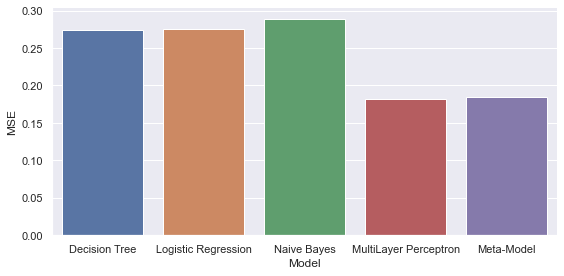

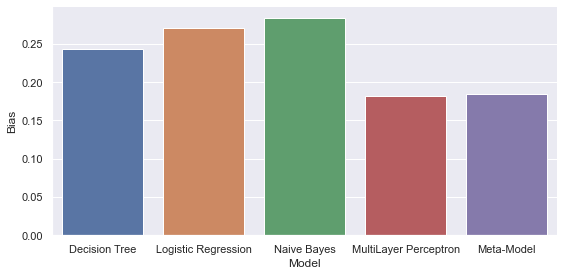

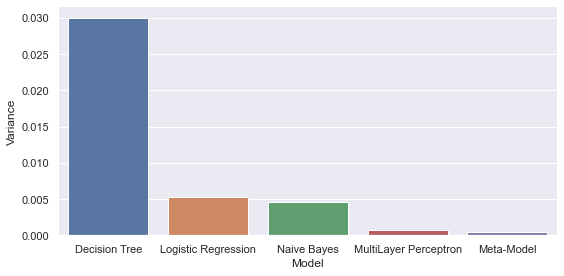

In [70]:
#Plotting a histogram of all the MSE, Bias and Variances of our models

for var in overall_metrics:
    if var!='Model':
        sb.catplot(data=overall_metrics, x="Model", y=var, height=4, aspect=2, kind='bar')
        count=count+1

As above, our meta-model did not have a significant impact on the MSE and bias, only managing to lower the already low variance of the MLP slightly.

## 5.2 Accuracy

In [71]:
test_acc_df={'Model': ['Meta-Model'], 'Accuracy': [test_acc]}
overall_accuracy=pd.concat([L0_accuracy,pd.DataFrame(data=test_acc_df)], ignore_index=True)
print(overall_accuracy)

                   Model  Accuracy
0          Decision Tree  0.726974
1    Logistic Regression  0.725100
2            Naive Bayes  0.711507
3  MultiLayer Perceptron  0.731310
4             Meta-Model  0.729435


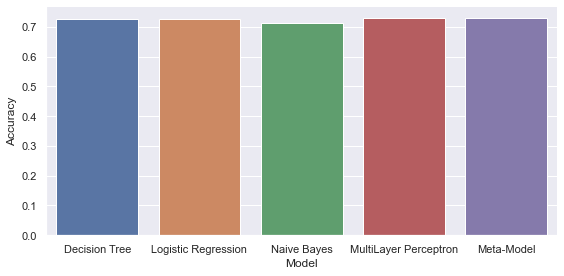

In [72]:
sb.catplot(data=overall_accuracy, x="Model", y='Accuracy', height=4, aspect=2, kind='bar')

As above, we can see our Meta-model actually has a marginally lower accuracy than our MLP. 

## 5.3 Conclusion

### 5.3.1 Overview

With the difference in accuracy between all our models being marginal at best, we will compare the accuracy of our models based on their efficiency. We will quantify the efficiency of our models through their train time complexity.

We will proceed to compare the train time complexities of our 3 most accurate models:
Decision Tree
MLP
Meta-Model

Before we begin the evaluation of time complexity for our models, we shall define the following variables:
n = input size
m = number of features in the training data

### 5.3.2 Train Time Complexity

#### Meta Model

As the meta-model requires the training of all base models prior to execution, the time complexity of the meta model is roughly given by ΣO(base models)+O(Level 1 Model). Clearly, the meta-model has a much greater time complexity than any of the base models.


#### Decision Tree

At each node:
Input data is sorted		–O(lg(n))

Gini value is calculated		–O(n)

Repeat steps 1 & 2 over m features 

Time complexity of each node: O(m⋅n⋅lg(n))

The worst-case scenario occurs if the tree is completely imbalanced, reulting in all data ending in one leaf node.
Hence, the worst case time complexity of a single tree is O(d⋅m⋅n⋅lg(n)), where d=depth of a decsion tree.

Testing for the optimal depth takes:
(From d=1 to 15){ Σdmnlg(n) = 15⋅m⋅n⋅lg(n) }

Subbing in the values:
15⋅12⋅n⋅lg(n)=O(n⋅lg(n))

#### MLP

As TensorFlow and Keras do not provide comprehensive documentation on the time complexity of their models, we will use the following expression for the time complexity of an MLP sourced from SkLearn Documentation:

O(n⋅m⋅h^k⋅o⋅e)  

Where n=sample size; m=no. of features; h=no. of hidden layers; k=no. of nodes in hidden layers;
o=no. of output nodes; e=no. of epochs.

Subbing in our values:
n⋅m⋅h^k⋅o⋅e = n⋅12⋅17⋅1⋅25⋅36=O(n)


#### Discussion

Although the MLP model is faster on paper, it is highly unlikely that the decision tree will run with worst case time complexity. Over 1000 trials, we found the decision tree to be the most efficient, with a train time of 0.05s and a test time of 0.002s

### 5.3.4 Final Thoughts

The takeaway here is that more does not always equal better when it comes to machine learning. Algorithms should only be as complex as the problems they are trying to solve; an overly complex solution to a simple problem will invariably result in a waste of computing resources.

In the context of this dataset being related to the prediction of cardiovascular disease, we reccomend that these predictive algorithms are, at best, able to assist healthcare professionals in the detection of cardiovascular disease.

# Appendix 1

Running the models over 1000 trials to obtain average runtime and accuracy scores

In [73]:
import time
from sklearn.metrics import mean_squared_error
# seed the pseudorandom number generator
from random import seed
from random import randint


In [74]:
from sklearn.tree import DecisionTreeClassifier
def traindectree(train, test, train_target, test_target):
    start=time.time()
    dectree = DecisionTreeClassifier(max_depth = 5).fit(train, train_target)
    accuracy = dectree.score(test, test_target)
    runtime= time.time()-start
    teststart=time.time()
    test_pred = dectree.predict(test)
    testtime=time.time()-teststart
    mse = mean_squared_error(test_target, test_pred)
    return accuracy, runtime, testtime, mse
    
def trainLogReg(train, test, train_target, test_target, seed):
    start=time.time()
    logreg = LogisticRegression(random_state=seed, max_iter=500).fit(train, train_target)
    accuracy = logreg.score(test, test_target)
    runtime= time.time()-start
    teststart=time.time()
    test_pred = logreg.predict(test)
    testtime=time.time()-teststart
    mse = mean_squared_error(test_target, test_pred)
    return accuracy, runtime, testtime, mse

def trainNB(train, test, train_target, test_target):
    start=time.time()
    NB = GaussianNB().fit(train,train_target)
    accuracy = NB.score(test, test_target)
    runtime= time.time()-start
    teststart=time.time()
    test_pred = NB.predict(test)
    testtime=time.time()-teststart
    mse = mean_squared_error(test_target, test_pred)
    return accuracy, runtime, testtime, mse

def trainMLP(train, test, train_target, test_target, seed):
    ctrain=pd.concat([train, train_target], axis=1)
    train_a, val = train_test_split(ctrain, test_size = (1.0/3))
    train_target = train_a.pop('cardio')
    val_target = val.pop('cardio')
    train_a=tf.convert_to_tensor(train_a)
    val=tf.convert_to_tensor(val)
    test=tf.convert_to_tensor(test)
    start=time.time()
    MLP=get_MLP(seed)
    MLP.fit(train_a, train_target, validation_data=(val, val_target), 
            epochs=36, batch_size=BATCH_SIZE, callbacks =[earlystopping], verbose=0)
    loss, accuracy = MLP.evaluate(test, test_target, verbose=0)
    runtime= time.time()-start
    teststart=time.time()
    predicted = MLP.predict(test)
    testtime=time.time()-teststart
    test_pred = [1 * (x[0]>=0.5) for x in predicted]
    mse = mean_squared_error(test_target, test_pred)
    return accuracy, runtime, testtime, mse

In [75]:
#Runtime Loop
model_list= ['Decision Tree', 'LogReg', 'Naive-Bayes', 'MLP']
numtrials = 1000
trial_accuracy = pd.DataFrame(0, index=[0], columns=model_list)
trial_runtime = pd.DataFrame(0, index=[0], columns=model_list)
trial_test_time = pd.DataFrame(0, index=[0], columns=model_list)
trial_MSE = pd.DataFrame(0, index=[0], columns=model_list)


for i in range (numtrials): #Resets the random seed for each trial
    seed=randint(1,1000)
    
    training_data, test_data = train_test_split(maindf, test_size = 0.25)
    train_target=training_data.pop('cardio')
    test_target=test_data.pop('cardio')
    
    acc, runtime, test_time, mse = traindectree(training_data, test_data, train_target, test_target)
    trial_accuracy['Decision Tree'] = trial_accuracy['Decision Tree']+acc
    trial_runtime['Decision Tree'] = trial_runtime['Decision Tree']+runtime
    trial_test_time['Decision Tree']= trial_test_time['Decision Tree']+test_time
    trial_MSE['Decision Tree'] = trial_MSE['Decision Tree']+mse
    
    acc, runtime, test_time, mse = trainLogReg(training_data, test_data, train_target, test_target, seed)
    trial_accuracy['LogReg'] = trial_accuracy['LogReg']+acc
    trial_runtime['LogReg'] = trial_runtime['LogReg']+runtime
    trial_test_time['LogReg']= trial_test_time['LogReg']+test_time
    trial_MSE['LogReg'] = trial_MSE['LogReg']+mse
    
    acc, runtime, test_time, mse = trainNB(training_data, test_data, train_target, test_target)
    trial_accuracy['Naive-Bayes'] = trial_accuracy['Naive-Bayes']+acc
    trial_runtime['Naive-Bayes'] = trial_runtime['Naive-Bayes']+runtime
    trial_test_time['Naive-Bayes']= trial_test_time['Naive-Bayes']+test_time
    trial_MSE['Naive-Bayes'] = trial_MSE['Naive-Bayes']+mse
    
    acc, runtime, test_time, mse = trainMLP(training_data, test_data, train_target, test_target, seed)
    trial_accuracy['MLP'] = trial_accuracy['MLP']+acc
    trial_runtime['MLP'] = trial_runtime['MLP']+runtime
    trial_test_time['MLP']= trial_test_time['MLP']+test_time
    trial_MSE['MLP'] = trial_MSE['MLP']+mse
    
    

534/534 [==============================] - 1s 1ms/step


534/534 [==============================] - 0s 753us/step


534/534 [==============================] - 0s 674us/step


534/534 [==============================] - 0s 733us/step


The average accuracy of our models over 1000 trials is as follows

In [76]:
trial_accuracy=trial_accuracy/numtrials
print(trial_accuracy)

   Decision Tree    LogReg  Naive-Bayes       MLP
0       0.729398  0.727143     0.712781  0.731775


The average training time of our models over 1000 trials is as follows

In [77]:
trial_runtime=trial_runtime/numtrials
print(trial_runtime)

   Decision Tree    LogReg  Naive-Bayes        MLP
0       0.059972  0.052488     0.015238  29.402331


The average test time of our models over 1000 trials is as follows

In [78]:
trial_test_time=trial_test_time/numtrials
print(trial_test_time)

   Decision Tree    LogReg  Naive-Bayes       MLP
0       0.001964  0.001272     0.003759  0.560049


The average MSE of our models over 1000 trials is as follows

In [79]:
trial_MSE=trial_MSE/numtrials
print(trial_MSE)

   Decision Tree    LogReg  Naive-Bayes       MLP
0       0.270602  0.272857     0.287219  0.268225
